In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import seaborn as sns
import itertools
import math

!pip install pyproj
!pip install adjustText

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

from scipy.stats import gaussian_kde
from scipy import stats
from scipy.stats import linregress
from scipy.stats import shapiro, ks_2samp, levene, ttest_ind, mannwhitneyu


from pyproj import Transformer

from adjustText import adjust_text

In [27]:
# Read the csv
df = pd.read_csv("AvulsionAngles.csv")
df2 = pd.read_csv("Profiles.csv")

In [28]:
# Define groups
group_1_fans = ["Niger", "Okavango", "Saskatchewan", "Shire", "Abrisham", "Ili"]
group_2_fans = ["Canning", "Karnali", "Kosi", "Manas"]
group_3_fans = ["Nomhon He", "Rud-i-Shur Tabas", "Cusay"]

# Function to assign groups
def assign_group(fan_name):
    if fan_name in group_1_fans:
        return "Group 1"
    elif fan_name in group_2_fans:
        return "Group 2"
    elif fan_name in group_3_fans:
        return "Group 3"
    elif fan_name in group_4_fans:
        return "Group 4"
    else:
        return "Other"

# Apply group assignment
df['Group'] = df['Fan'].apply(assign_group)


C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\300397706.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apex_rows['dist_to_true_apex'] = np.sqrt(
C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\300397706.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apex_rows['dist_to_true_apex'] = np.sqrt(
C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\300397706.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

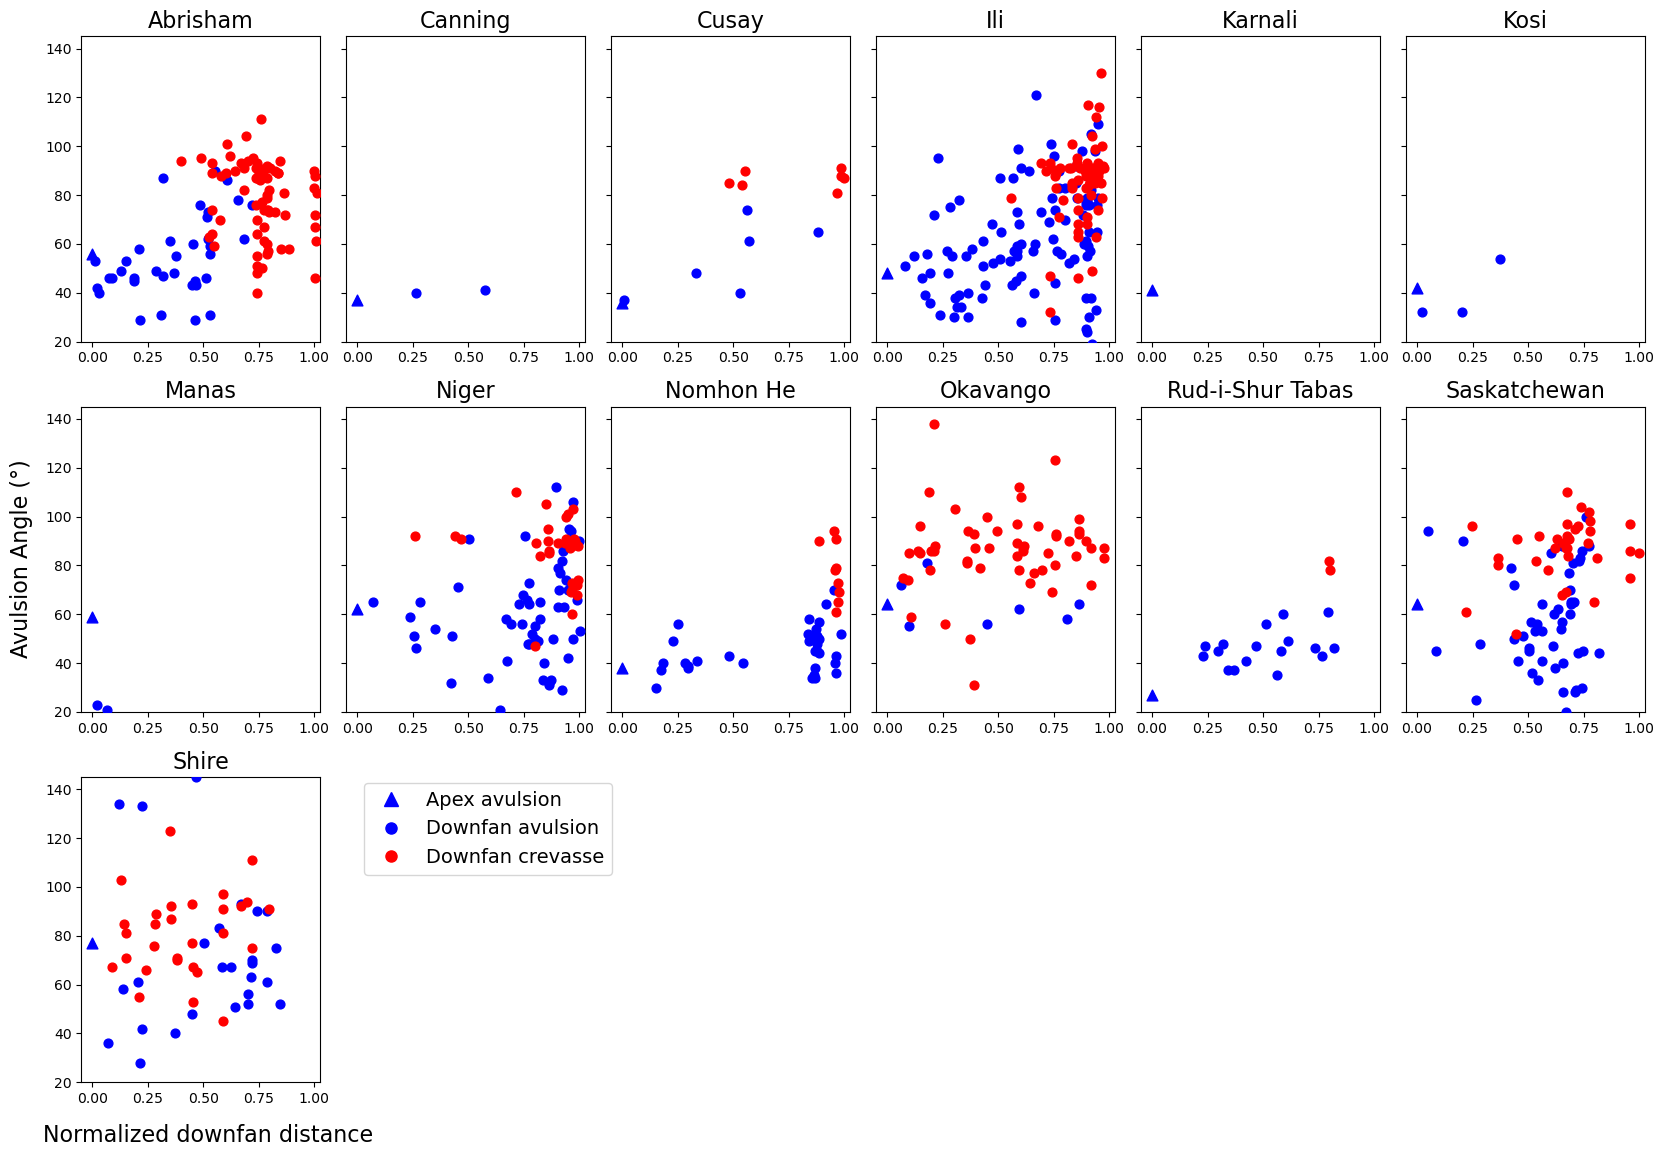

In [216]:
# ===============================================
# Step 0: Import and define utilities
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -------------------------------
# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c


# ===============================================
# Step 1: Define Apex and Toe coordinates
# ===============================================
apex_coords = {
    "Abrisham": (35.61570558, 56.2550051),
    "Canning": (69.851, -146.461),
    "Cusay": (6.69162445, -71.84111181),
    "Ili": (44.8169747, 76.2228272),
    "Karnali": (28.610688, 81.2744661),
    "Kosi": (26.53, 86.938),
    "Manas": (26.78284555, 90.95510889),
    "Niger": (14.13861504, -5.02443996),
    "Nomhon He": (36.209, 96.385),
    "Okavango": (-18.858, 22.382),
    "Rud-i-Shur Tabas": (32.69999266, 60.54639206),
    "Saskatchewan": (53.70749938, -103.22863607),
    "Shire": (-16.2056, 34.9333)
}

toe_coords = {
    "Abrisham": (35.4077960, 55.9442017),
    "Canning": (70.0776829, -145.8115939),
    "Cusay": (6.70164919, -71.1415035),
    "Ili": (46.5798760, 75.4267887),
    "Karnali": (28.272984, 81.0855275),
    "Kosi": (25.4124270, 87.2551879),
    "Manas": (26.2501896, 90.817693),
    "Niger": (15.29728494, -3.97095891),
    "Nomhon He": (36.5690979, 96.467773),
    "Okavango": (-19.2357331, 23.9332574),
    "Rud-i-Shur Tabas": (32.6369173, 60.8883672),
    "Saskatchewan": (53.67753298, -102.10288441),
    "Shire": (-16.5488535, 35.12352637)
}


# ===============================================
# Step 2: Clean and preprocess DataFrame
# ===============================================
df['Apex'] = df['Apex'].astype(str).str.strip()
df['Crevasse'] = df['Crevasse'].astype(str).str.strip()
df['Angle'] = pd.to_numeric(df['Angle'], errors='coerce')


# --------------------------------------------------
# Step 2.5: Choose a single reference apex per fan (for distance normalization)
# --------------------------------------------------
ref_apex_index = {}

for fan in df['Fan'].unique():
    if fan not in apex_coords:
        continue

    apex_lat, apex_lon = apex_coords[fan]
    fan_rows = df[df['Fan'] == fan].copy()
    apex_rows = fan_rows[fan_rows['Apex'] == 'Yes']

    if len(apex_rows) > 0:
        # Distance from each apex row to the defined coordinate
        apex_rows['dist_to_true_apex'] = np.sqrt(
            (apex_rows['Latitude'] - apex_lat)**2 + (apex_rows['Longitude'] - apex_lon)**2
        )
        ref_apex_index[fan] = apex_rows.loc[apex_rows['dist_to_true_apex'].idxmin()].name
    else:
        ref_apex_index[fan] = None


# ===============================================
# Step 3: Compute normalized distances
# ===============================================
df['Distance_m'] = np.nan
df['Distance_norm'] = np.nan

for fan in df['Fan'].unique():
    if fan not in apex_coords or fan not in toe_coords:
        continue

    apex_lat, apex_lon = apex_coords[fan]
    toe_lat, toe_lon = toe_coords[fan]

    total_dist = haversine(apex_lat, apex_lon, toe_lat, toe_lon)
    fan_mask = df['Fan'] == fan

    # Distance from defined apex to each node
    df.loc[fan_mask, 'Distance_m'] = df.loc[fan_mask].apply(
        lambda row: haversine(apex_lat, apex_lon, row['Latitude'], row['Longitude']),
        axis=1
    )

    # Normalize distances (ensure reference apex is 0)
    if total_dist == 0:
        df.loc[fan_mask, 'Distance_norm'] = 0
    else:
        df.loc[fan_mask, 'Distance_norm'] = df.loc[fan_mask, 'Distance_m'] / total_dist

    if ref_apex_index[fan] is not None:
        df.loc[ref_apex_index[fan], 'Distance_norm'] = 0


# ===============================================
# Step 4: Plot each fan (normalized distance)
# ===============================================
fan_list = df['Fan'].unique()
n_fans = len(fan_list)
n_cols = 6
n_rows = int(np.ceil(n_fans / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4), sharey=True)
axes = axes.flatten()

for i, fan in enumerate(fan_list):
    fan_data = df[df['Fan'] == fan]

    if fan_data.empty:
        axes[i].axis('off')
        continue

    # Plot all Apex = Yes rows as blue triangles
    apex_points = fan_data[fan_data['Apex'] == 'Yes']
    axes[i].scatter(apex_points['Distance_norm'], apex_points['Angle'],
                    c='blue', marker='^', s=60, zorder=5, label='Apex')

    # Downfan points
    downfan_points = fan_data[fan_data['Apex'] == 'No']
    if not downfan_points.empty:
        crev_no = downfan_points[downfan_points['Crevasse'] == 'No']
        crev_yes = downfan_points[downfan_points['Crevasse'] == 'Yes']

        axes[i].scatter(crev_no['Distance_norm'], crev_no['Angle'],
                        c='blue', marker='o', s=40, zorder=4, label='Avulsion')
        axes[i].scatter(crev_yes['Distance_norm'], crev_yes['Angle'],
                        c='red', marker='o', s=40, zorder=4, label='Crevasse')

    axes[i].set_title(fan, fontsize=16)
    axes[i].set_xlim(-0.05, 1.025)
    axes[i].set_ylim(20, 145)
    axes[i].grid(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# ===============================================
# Step 5: Global legend and labels
# ===============================================
legend_elements = [
    Line2D([0], [0], marker='^', color='blue', linestyle='None', markersize=10, label='Apex avulsion'),
    Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=8, label='Downfan avulsion'),
    Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=8, label='Downfan crevasse')
]

fig.legend(handles=legend_elements, loc='right', bbox_to_anchor=(0.35, 0.275), fontsize=14)
fig.supxlabel('Normalized downfan distance', fontsize=16, x=0.12)
fig.supylabel('Avulsion Angle (°)', fontsize=16, x=0.01)

plt.tight_layout(rect=[0, 0, 0.93, 0.97])
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\3092770050.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\3092770050.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_all = df_plot_all.groupby('Group')['Angle']


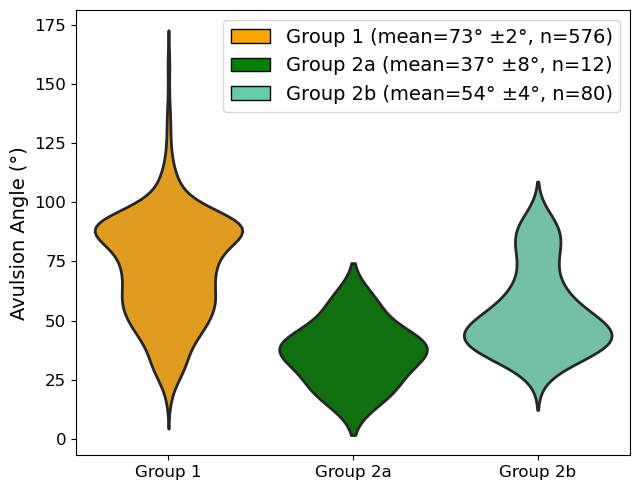

In [87]:
# -----------------------------
# Violin Plot: All Angles
# -----------------------------
x_label = ""
y_label = "Avulsion Angle (°)"
title_all = ""
order = ['Group 1', 'Group 2a', 'Group 2b']

# Filter data
df_plot_all = df[df['Group'].isin(order)].copy()
df_plot_all['Group'] = pd.Categorical(df_plot_all['Group'], categories=order, ordered=True)

# --- Adjustable font sizes ---
title_font = 16
label_font = 14
tick_font = 12
legend_font = 14  # legend text size

plt.figure(figsize=(6.5, 5))
ax = sns.violinplot(
    x='Group',
    y='Angle',
    data=df_plot_all,
    order=order,
    palette=colors,
    linewidth=2,
    inner=None
)

# Compute mean, count, and 95% CI
grouped_all = df_plot_all.groupby('Group')['Angle']
means_all = grouped_all.mean()
counts_all = grouped_all.count()

ci_dict_all = {}
for g in order:
    xdata = df_plot_all[df_plot_all['Group'] == g]['Angle']
    if len(xdata) > 1:
        ci_low, ci_high = stats.t.interval(
            0.95, len(xdata)-1,
            loc=means_all[g], scale=stats.sem(xdata)
        )
        ci_dict_all[g] = (ci_low, ci_high)
    elif len(xdata) == 1:
        ci_dict_all[g] = (means_all[g], means_all[g])

# Legend with degree symbol and no decimals
legend_elements = []
for g in order:
    if g in means_all:
        ci_low, ci_high = ci_dict_all[g]
        mean_val = round(means_all[g])
        ci_half = round(ci_high - means_all[g])
        label = f"{g} (mean={mean_val}° ±{ci_half}°, n={counts_all[g]})"
        legend_elements.append(Patch(facecolor=colors[g], edgecolor='k', label=label))

ax.legend(handles=legend_elements, fontsize=legend_font, loc='upper right')
ax.set_title(title_all, fontsize=title_font)
ax.set_xlabel(x_label, fontsize=label_font)
ax.set_ylabel(y_label, fontsize=label_font)
ax.tick_params(axis='both', labelsize=tick_font)
ax.grid(False)

plt.tight_layout()
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\265637606.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\265637606.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_apex = df_plot_apex.groupby('Group')['Angle']


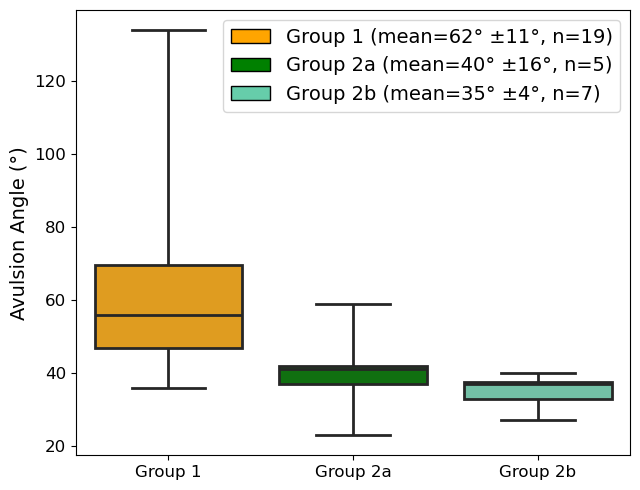

In [88]:
# -----------------------------
# Box Plot: Apex Angles
# -----------------------------
x_label = ""  # match previous style
y_label = "Avulsion Angle (°)"
title_apex = ""  # no title for consistency
order = ['Group 1', 'Group 2a', 'Group 2b']

# Filter data
df_plot_apex = df[(df['Group'].isin(order)) & (df['Apex'] == 'Yes')].copy()
df_plot_apex['Group'] = pd.Categorical(df_plot_apex['Group'], categories=order, ordered=True)

# --- Adjustable font sizes (consistent with violin plot) ---
title_font = 16
label_font = 14
tick_font = 12
legend_font = 14  # match previous figure

plt.figure(figsize=(6.5, 5))
ax = sns.boxplot(
    x='Group',
    y='Angle',
    data=df_plot_apex,
    order=order,
    palette=colors,
    showfliers=False,
    linewidth=2,
    whis=[0, 100]
)

# Compute mean, count, and 95% CI
grouped_apex = df_plot_apex.groupby('Group')['Angle']
means_apex = grouped_apex.mean()
counts_apex = grouped_apex.count()

ci_dict_apex = {}
for g in order:
    xdata = df_plot_apex[df_plot_apex['Group'] == g]['Angle']
    if len(xdata) > 1:
        ci_low, ci_high = stats.t.interval(
            0.95, len(xdata)-1,
            loc=means_apex[g], scale=stats.sem(xdata)
        )
        ci_dict_apex[g] = (ci_low, ci_high)
    elif len(xdata) == 1:
        ci_dict_apex[g] = (means_apex[g], means_apex[g])

# Legend with degree symbol and integer rounding
legend_elements = []
for g in order:
    if g in means_apex:
        ci_low, ci_high = ci_dict_apex[g]
        mean_val = round(means_apex[g])
        ci_half = round(ci_high - means_apex[g])
        label = f"{g} (mean={mean_val}° ±{ci_half}°, n={counts_apex[g]})"
        legend_elements.append(Patch(facecolor=colors[g], edgecolor='k', label=label))

ax.legend(handles=legend_elements, fontsize=legend_font, loc='upper right')
ax.set_title(title_apex, fontsize=title_font)
ax.set_xlabel(x_label, fontsize=label_font)
ax.set_ylabel(y_label, fontsize=label_font)
ax.tick_params(axis='both', labelsize=tick_font)
ax.grid(False)

plt.tight_layout()
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\3654848587.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


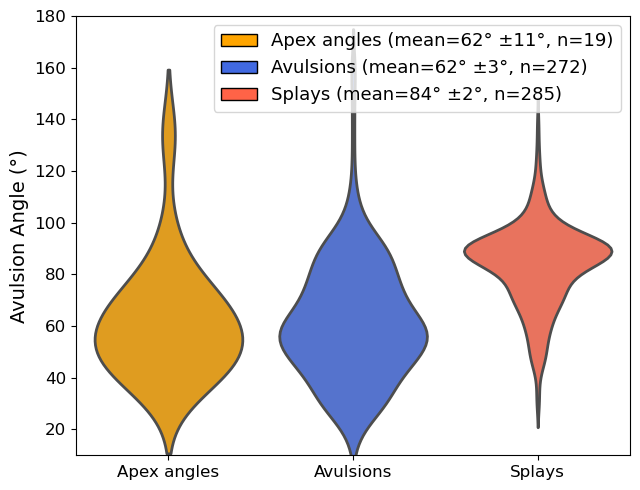

In [157]:
# -----------------------------
# Group 1 Violin Plot
# -----------------------------
x_label = ""  # omit large x-axis label
y_label = "Avulsion Angle (°)"  # keep y-axis label
title_group1 = ""
order_conditions = ["Apex angles", "Avulsions", "Splays"]
default_colors = {"Avulsions": "royalblue", "Splays": "tomato"}
apex_color = "orange"  # Group 1 color

# --- Adjustable fonts and sizing ---
title_font = 16
label_font = 14
tick_font = 12
legend_font = 13

plt.figure(figsize=(6.5, 5))

# Prepare data
df_g1 = df[df["Group"] == "Group 1"].copy()
df_g1["Condition"] = np.select(
    [
        df_g1["Apex"] == "Yes",
        df_g1["Crevasse"] == "No",
        df_g1["Crevasse"] == "Yes",
    ],
    ["Apex angles", "Avulsions", "Splays"],
    default=np.nan
)
df_g1 = df_g1[df_g1["Condition"].isin(order_conditions)]
df_g1["Condition"] = pd.Categorical(df_g1["Condition"], categories=order_conditions, ordered=True)

# Palette
palette = {
    "Apex angles": apex_color,                # Group 1 = orange
    "Avulsions": default_colors["Avulsions"], # blue
    "Splays": default_colors["Splays"],       # red
}

# Plot violin
ax = sns.violinplot(
    data=df_g1,
    x="Condition",
    y="Angle",
    palette=palette,
    linewidth=2,
    inner=None,
)

# Compute stats for legend
legend_elements = []
for cond in order_conditions:
    cond_data = df_g1[df_g1["Condition"] == cond]["Angle"]
    if not cond_data.empty:
        n = len(cond_data)
        mean = round(cond_data.mean())
        sem = stats.sem(cond_data)
        ci = round(sem * stats.t.ppf((1 + 0.95) / 2., n - 1)) if n > 1 else 0
        label = f"{cond} (mean={mean}° ±{ci}°, n={n})"
        legend_elements.append(Patch(facecolor=palette[cond], edgecolor="k", label=label))

# Legend and formatting
ax.legend(handles=legend_elements, fontsize=legend_font, loc="upper right")
ax.set_title(title_group1, fontsize=title_font)
ax.set_xlabel("")  # no main x-axis label
ax.set_ylabel(y_label, fontsize=label_font)
ax.tick_params(axis="both", labelsize=tick_font)
ax.grid(False)

# --- Fixed y-axis range ---
ax.set_ylim(10, 180)

plt.tight_layout()
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\2565575211.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


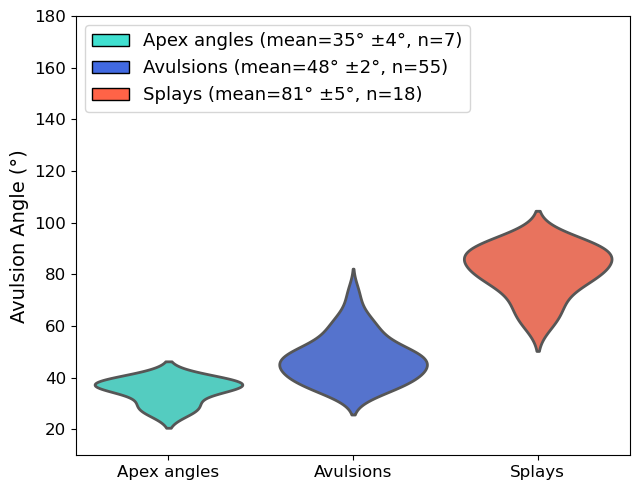

In [158]:
# -----------------------------
# Group 2b Violin Plot
# -----------------------------
x_label = ""  # omit large x-axis label
y_label = "Avulsion Angle (°)"  # keep y-axis label
title_group2b = ""  # no title for consistent style
order_conditions = ["Apex angles", "Avulsions", "Splays"]
default_colors = {"Avulsions": "royalblue", "Splays": "tomato"}
apex_color = "turquoise"  # Group 2b color

# --- Adjustable fonts and sizing ---
title_font = 16
label_font = 14
tick_font = 12
legend_font = 13

plt.figure(figsize=(6.5, 5))

# Prepare data
df_g2b = df[df["Group"] == "Group 2b"].copy()
df_g2b["Condition"] = np.select(
    [
        df_g2b["Apex"] == "Yes",
        df_g2b["Crevasse"] == "No",
        df_g2b["Crevasse"] == "Yes",
    ],
    ["Apex angles", "Avulsions", "Splays"],
    default=np.nan
)
df_g2b = df_g2b[df_g2b["Condition"].isin(order_conditions)]
df_g2b["Condition"] = pd.Categorical(df_g2b["Condition"], categories=order_conditions, ordered=True)

# Palette
palette = {
    "Apex angles": apex_color,                # Group 2b = turquoise
    "Avulsions": default_colors["Avulsions"], # blue
    "Splays": default_colors["Splays"],       # red
}

# Plot violin
ax = sns.violinplot(
    data=df_g2b,
    x="Condition",
    y="Angle",
    palette=palette,
    linewidth=2,
    inner=None,
)

# Compute stats for legend
legend_elements = []
for cond in order_conditions:
    cond_data = df_g2b[df_g2b["Condition"] == cond]["Angle"]
    if not cond_data.empty:
        n = len(cond_data)
        mean = round(cond_data.mean())
        sem = stats.sem(cond_data)
        ci = round(sem * stats.t.ppf((1 + 0.95) / 2., n - 1)) if n > 1 else 0
        label = f"{cond} (mean={mean}° ±{ci}°, n={n})"
        legend_elements.append(Patch(facecolor=palette[cond], edgecolor="k", label=label))

# Legend and formatting
ax.legend(handles=legend_elements, fontsize=legend_font, loc="upper left")  # top-left legend
ax.set_title(title_group2b, fontsize=title_font)
ax.set_xlabel("")  # no main x-axis label
ax.set_ylabel(y_label, fontsize=label_font)
ax.tick_params(axis="both", labelsize=tick_font)
ax.grid(False)

# --- Fixed y-axis range ---
ax.set_ylim(10, 180)

plt.tight_layout()
plt.show()


In [100]:
# Ensure Distance is in meters (if it's in km, multiply by 1000)
df2['Distance_m'] = df2['Distance'] * 1000

# Prepare list to collect results
gradient_table = []

# Loop through each fan
for fan_name in df2['Fan'].unique():
    df_fan = df2[df2['Fan'] == fan_name].sort_values('Distance_m').copy()
    
    # Find Apex index
    apex_idx = df_fan[df_fan['Apex'] == 'Apex'].index
    if len(apex_idx) == 0:
        print(f"Warning: no Apex found for fan {fan_name}")
        continue
    apex_idx = apex_idx[0]  # take first Apex if multiple
    
    # Drainage gradient: first row to Apex
    drainage_dist = df_fan.loc[:apex_idx, 'Distance_m'].values
    drainage_elev = df_fan.loc[:apex_idx, 'River Elevation'].values
    drainage_slope_rad = np.gradient(drainage_elev, drainage_dist)
    drainage_slope_deg = np.degrees(np.mean(np.abs(drainage_slope_rad)))
    
    # Fan gradient: Apex to last row
    fan_dist = df_fan.loc[apex_idx:, 'Distance_m'].values
    fan_elev = df_fan.loc[apex_idx:, 'River Elevation'].values
    fan_slope_rad = np.gradient(fan_elev, fan_dist)
    fan_slope_deg = np.degrees(np.mean(np.abs(fan_slope_rad)))
    
    # Add to table
    gradient_table.append({
        'Fan': fan_name,
        'Drainage Gradient (°)': drainage_slope_deg,
        'Fan Gradient (°)': fan_slope_deg,
        'Gradient Ratio (Drainage/Fan)': drainage_slope_deg / fan_slope_deg if fan_slope_deg != 0 else np.nan
    })

# Convert to DataFrame
gradient_df = pd.DataFrame(gradient_table)

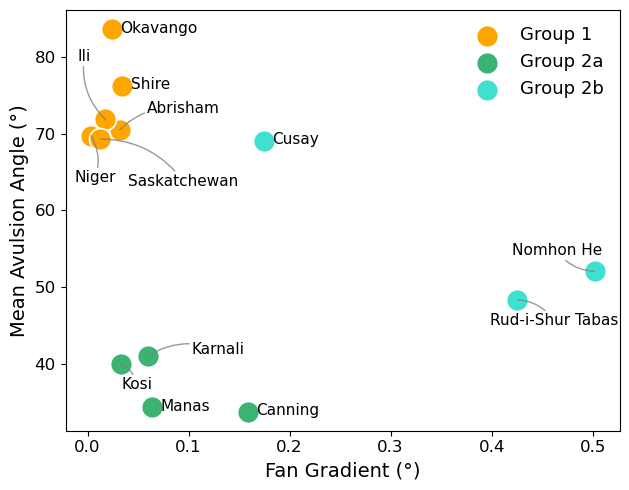

In [159]:
# =============================================
# Plot 1: Mean Avulsion Angle vs Fan Gradient
# =============================================

line_fans = {
    "Ili": {"dx": -0.05, "dy": 0.15},
    "Abrisham": {"dx": 0.05, "dy": 0.05},
    "Niger": {"dx": -0.03, "dy": -0.1},
    "Saskatchewan": {"dx": 0.05, "dy": -0.1},
    "Kosi": {"dx": 0.0, "dy": -0.05},
    "Karnali": {"dx": 0.08, "dy": 0.015},
    "Nomhon He": {"dx": -0.15, "dy": 0.05},
    "Rud-i-Shur Tabas": {"dx": -0.05, "dy": -0.05},
}

# --- Updated group colors ---
colors = {
    "Group 1": "orange",
    "Group 2a": "mediumseagreen",   # <-- green tone
    "Group 2b": "turquoise"
}

# --- Font & style settings ---
label_font = 14
tick_font = 12
legend_font = 13
text_font = 11
arrow_color = "gray"

# ---------------------------------------------
# Helper: label with optional connector line
# ---------------------------------------------
def smart_label(ax, x, y, fan, offsets=None, color="black"):
    ax.figure.canvas.draw()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    dx_base = 0.075 * (xlim[1] - xlim[0])
    dy_base = 0.012 * (ylim[1] - ylim[0])

    if offsets:
        dx_scaled = offsets.get("dx", 0.075) * (xlim[1] - xlim[0])
        dy_scaled = offsets.get("dy", 0.012) * (ylim[1] - ylim[0])
    else:
        dx_scaled, dy_scaled = dx_base, dy_base

    x_label = x + dx_scaled
    y_label = y + dy_scaled

    # Keep labels inside bounds
    x_label = min(x_label, xlim[1] - 0.015 * (xlim[1] - xlim[0]))
    y_label = min(y_label, ylim[1] - 0.01 * (ylim[1] - ylim[0]))

    ax.annotate(
        fan,
        xy=(x, y),
        xytext=(x_label, y_label),
        fontsize=text_font,
        ha="left",
        va="center",
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            lw=1.0,
            color=arrow_color,
            alpha=0.8,
            shrinkA=0,
            shrinkB=0,
            connectionstyle="arc3,rad=0.25"
        ),
    )

# ---------------------------------------------
# Create scatter plot
# ---------------------------------------------
fig, ax = plt.subplots(figsize=(6.5, 5))

for group in ["Group 1", "Group 2a", "Group 2b"]:
    data = plot_df[(plot_df["Group"] == group) & (plot_df["mean_angle"].notna())]
    sns.scatterplot(
        data=data,
        x="Fan Gradient (°)",
        y="mean_angle",
        s=250,
        color=colors[group],
        label=group,
        ax=ax
    )

ax.set_xlabel("Fan Gradient (°)", fontsize=label_font)
ax.set_ylabel("Mean Avulsion Angle (°)", fontsize=label_font)
ax.tick_params(axis="both", labelsize=tick_font)
ax.legend(fontsize=legend_font, loc="upper right", frameon=False)
ax.grid(False)
ax.figure.canvas.draw()

# ---------------------------------------------
# Label points (with offsets if defined)
# ---------------------------------------------
for _, row in plot_df.iterrows():
    if pd.notna(row["mean_angle"]):
        if row["Fan"] in line_fans:
            smart_label(
                ax,
                row["Fan Gradient (°)"],
                row["mean_angle"],
                row["Fan"],
                offsets=line_fans[row["Fan"]],
            )
        else:
            ax.text(
                row["Fan Gradient (°)"] + 0.015 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
                row["mean_angle"] + 0.002 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                row["Fan"],
                fontsize=text_font,
                ha="left",
                va="center",
                color="black",
            )

plt.tight_layout()
plt.show()


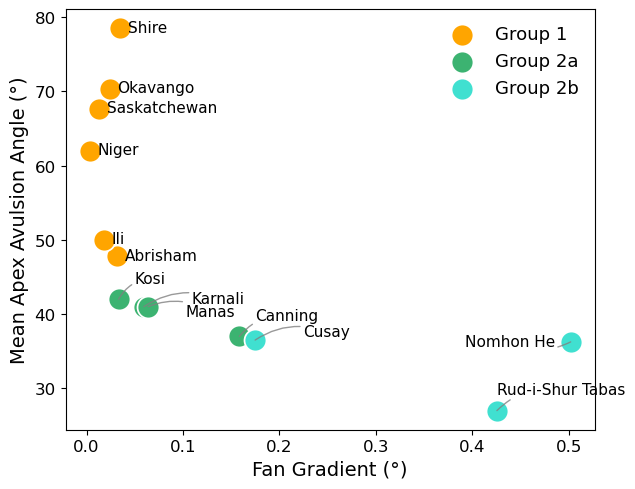

In [160]:
# =============================================
# Plot 2: Mean Apex Avulsion Angle vs Fan Gradient
# =============================================

# Fans that need leader lines (custom offsets)
line_fans = {
    "Kosi": {"dx": 0.03, "dy": 0.05},
    "Karnali": {"dx": 0.09, "dy": 0.02},
    "Manas": {"dx": 0.07, "dy": -0.012},
    "Canning": {"dx": 0.03, "dy": 0.05},
    "Cusay": {"dx": 0.09, "dy": 0.02},
    "Nomhon He": {"dx": -0.2, "dy": 0.0},
    "Rud-i-Shur Tabas": {"dx": 0.0, "dy": 0.05},
}

# Consistent group colors
colors = {
    "Group 1": "orange",
    "Group 2a": "mediumseagreen",
    "Group 2b": "turquoise"
}

# Font & style settings
label_font = 14
tick_font = 12
legend_font = 13
text_font = 11
arrow_color = "gray"

# ---------------------------------------------
# Helper for labeling
# ---------------------------------------------
def smart_label(ax, x, y, fan, offsets=None, color="black"):
    ax.figure.canvas.draw()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    dx_base = 0.075 * (xlim[1] - xlim[0])
    dy_base = 0.012 * (ylim[1] - ylim[0])

    if offsets:
        dx_scaled = offsets.get("dx", 0.075) * (xlim[1] - xlim[0])
        dy_scaled = offsets.get("dy", 0.012) * (ylim[1] - ylim[0])
    else:
        dx_scaled, dy_scaled = dx_base, dy_base

    x_label = x + dx_scaled
    y_label = y + dy_scaled

    # Keep labels inside plot bounds
    x_label = min(x_label, xlim[1] - 0.015 * (xlim[1] - xlim[0]))
    y_label = min(y_label, ylim[1] - 0.01 * (ylim[1] - ylim[0]))

    ax.annotate(
        fan,
        xy=(x, y),
        xytext=(x_label, y_label),
        fontsize=text_font,
        ha="left",
        va="center",
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            lw=1.0,
            color=arrow_color,
            alpha=0.8,
            shrinkA=0,
            shrinkB=0,
            connectionstyle="arc3,rad=0.25"
        ),
    )

# ---------------------------------------------
# Create Plot
# ---------------------------------------------
fig, ax = plt.subplots(figsize=(6.5, 5))

for group in ["Group 1", "Group 2a", "Group 2b"]:
    data = plot_df[(plot_df["Group"] == group) & (plot_df["mean_apex_angle"].notna())]
    sns.scatterplot(
        data=data,
        x="Fan Gradient (°)",
        y="mean_apex_angle",
        s=250,
        color=colors[group],
        label=group,
        ax=ax
    )

ax.set_xlabel("Fan Gradient (°)", fontsize=label_font)
ax.set_ylabel("Mean Apex Avulsion Angle (°)", fontsize=label_font)
ax.tick_params(axis="both", labelsize=tick_font)
ax.legend(fontsize=legend_font, loc="upper right", frameon=False)
ax.grid(False)
ax.figure.canvas.draw()

# ---------------------------------------------
# Label points
# ---------------------------------------------
for _, row in plot_df.iterrows():
    if pd.notna(row["mean_apex_angle"]):
        if row["Fan"] in line_fans:
            smart_label(
                ax,
                row["Fan Gradient (°)"],
                row["mean_apex_angle"],
                row["Fan"],
                offsets=line_fans[row["Fan"]],
            )
        else:
            ax.text(
                row["Fan Gradient (°)"] + 0.015 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
                row["mean_apex_angle"] + 0.002 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                row["Fan"],
                fontsize=text_font,
                ha="left",
                va="center",
                color="black",
            )

plt.tight_layout()
plt.show()


C:\Users\lukej\AppData\Local\Temp\ipykernel_65016\2145395094.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


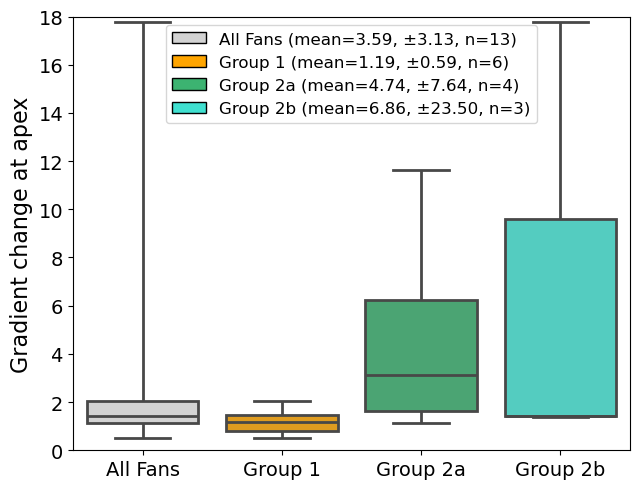

In [165]:
# ----------------------------------------
# Add "All Fans" color (light gray)
# ----------------------------------------
all_colors = colors.copy()
all_colors["All Fans"] = "lightgray"

# ----------------------------------------
# Prepare plot_data
# ----------------------------------------
all_fans_df = gradient_df[['Fan', 'Gradient Ratio (Drainage/Fan)']].copy()
all_fans_df['Category'] = 'All Fans'
all_fans_df = all_fans_df.rename(columns={'Gradient Ratio (Drainage/Fan)': 'ratio'})

group_df = gradient_df[['Fan', 'Gradient Ratio (Drainage/Fan)', 'Group']].copy()
group_df = group_df.rename(columns={'Gradient Ratio (Drainage/Fan)': 'ratio', 'Group': 'Category'})

# Keep only Groups 1, 2a, 2b
group_df = group_df[group_df['Category'].isin(['Group 1', 'Group 2a', 'Group 2b'])]

# Combine datasets
plot_data = pd.concat([all_fans_df, group_df], ignore_index=True)

# ----------------------------------------
# Define order and color palette
# ----------------------------------------
category_order = ["All Fans", "Group 1", "Group 2a", "Group 2b"]
palette = [all_colors.get(c, 'lightgray') for c in category_order]

# ----------------------------------------
# Plot boxplot
# ----------------------------------------
plt.figure(figsize=(6.5, 5))
ax = sns.boxplot(
    x='Category',
    y='ratio',
    data=plot_data,
    palette=palette,
    showfliers=False,
    linewidth=2,
    whis=[0, 100],
    order=category_order
)

# ----------------------------------------
# Add legend with mean ± 95% CI
# ----------------------------------------
legend_elements = []
for c in category_order:
    xdata = plot_data[plot_data['Category'] == c]['ratio']
    n_val = len(xdata)
    if n_val > 1:
        mean_val = xdata.mean()
        ci = stats.t.interval(0.95, n_val-1, loc=mean_val, scale=stats.sem(xdata))
        ci_val = ci[1] - mean_val
    elif n_val == 1:
        mean_val = xdata.iloc[0]
        ci_val = 0
    else:
        mean_val = 0
        ci_val = 0

    legend_elements.append(
        Patch(facecolor=all_colors.get(c, 'lightgray'), edgecolor='k',
              label=f"{c} (mean={mean_val:.2f}, ±{ci_val:.2f}, n={n_val})")
    )

# ----------------------------------------
# Format axes and legend
# ----------------------------------------
plt.xlabel("", fontsize=16)
plt.ylabel("Gradient change at apex", fontsize=16)
plt.title("", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 18)
plt.grid(False)
plt.legend(handles=legend_elements, fontsize=12, loc='upper center')
plt.tight_layout()
plt.show()


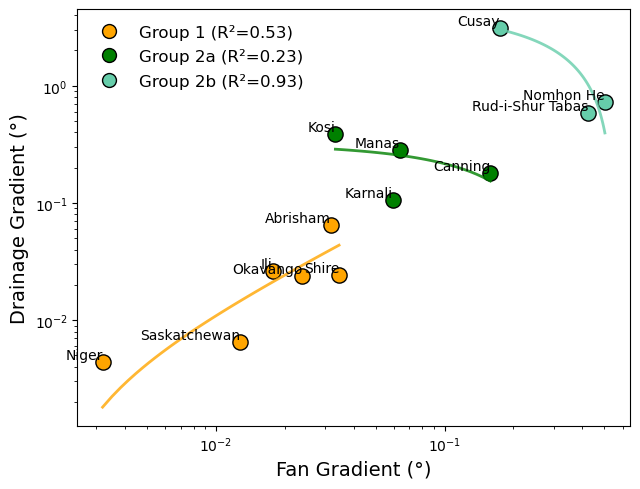

In [171]:
# -----------------------------------------------------
# Define groups and updated colors
# -----------------------------------------------------
group_1_fans = ["Niger", "Okavango", "Saskatchewan", "Shire", "Abrisham", "Ili"]
group_2a_fans = ["Canning", "Karnali", "Kosi", "Manas"]
group_2b_fans = ["Nomhon He", "Rud-i-Shur Tabas", "Cusay"]

colors = {
    "Group 1": "orange",              # Group 1 → orange
    "Group 2a": "green",              # Group 2a → green
    "Group 2b": "mediumaquamarine"    # Group 2b → medium aquamarine
}

def assign_group(fan):
    if fan in group_1_fans:
        return "Group 1"
    elif fan in group_2a_fans:
        return "Group 2a"
    elif fan in group_2b_fans:
        return "Group 2b"
    else:
        return np.nan

# -----------------------------------------------------
# Compute gradients
# -----------------------------------------------------
df2['Distance_m'] = df2['Distance'] * 1000
gradient_table = []

for fan_name in df2['Fan'].unique():
    df_fan = df2[df2['Fan'] == fan_name].sort_values('Distance_m').copy()

    apex_idx = df_fan[df_fan['Apex'] == 'Apex'].index
    if len(apex_idx) == 0:
        print(f"⚠️ Warning: no Apex found for fan {fan_name}")
        continue
    apex_idx = apex_idx[0]

    # Drainage gradient
    drainage_dist = df_fan.loc[:apex_idx, 'Distance_m'].values
    drainage_elev = df_fan.loc[:apex_idx, 'River Elevation'].values
    drainage_slope_deg = np.degrees(np.mean(np.abs(np.gradient(drainage_elev, drainage_dist))))

    # Fan gradient
    fan_dist = df_fan.loc[apex_idx:, 'Distance_m'].values
    fan_elev = df_fan.loc[apex_idx:, 'River Elevation'].values
    fan_slope_deg = np.degrees(np.mean(np.abs(np.gradient(fan_elev, fan_dist))))

    gradient_table.append({
        "Fan": fan_name,
        "Drainage Gradient (°)": drainage_slope_deg,
        "Fan Gradient (°)": fan_slope_deg,
        "Gradient Ratio (Drainage/Fan)": drainage_slope_deg / fan_slope_deg if fan_slope_deg != 0 else np.nan
    })

gradient_df = pd.DataFrame(gradient_table)
gradient_df["Group"] = gradient_df["Fan"].apply(assign_group)
gradient_df = gradient_df[gradient_df["Group"].isin(["Group 1", "Group 2a", "Group 2b"])]

# -----------------------------------------------------
# Scatter plot: Drainage vs Fan Gradients
# -----------------------------------------------------
plt.figure(figsize=(6.5, 5))

# Custom legend handles
legend_handles = []

for group_name, group_color in colors.items():
    subset = gradient_df[gradient_df["Group"] == group_name]
    if len(subset) == 0:
        continue

    # Scatter points
    plt.scatter(
        subset["Fan Gradient (°)"],
        subset["Drainage Gradient (°)"],
        s=120,
        color=group_color,
        edgecolor="black"
    )

    # Regression line
    if len(subset) > 1:
        slope, intercept, r_value, _, _ = linregress(
            subset["Fan Gradient (°)"], subset["Drainage Gradient (°)"])
        x_vals = np.linspace(subset["Fan Gradient (°)"].min(), subset["Fan Gradient (°)"].max(), 100)
        plt.plot(
            x_vals,
            slope * x_vals + intercept,
            color=group_color,
            linestyle="-",
            lw=2,
            alpha=0.8
        )
        label = f"{group_name} (R²={r_value**2:.2f})"
    else:
        label = group_name

    # Add circular marker to legend (not line)
    legend_handles.append(plt.Line2D(
        [0], [0], marker='o', color='w', markerfacecolor=group_color,
        markeredgecolor='black', markersize=10, label=label
    ))

# Fan labels
for _, row in gradient_df.iterrows():
    plt.text(
        row["Fan Gradient (°)"],
        row["Drainage Gradient (°)"],
        row["Fan"],
        fontsize=10,
        ha="right",
        va="bottom"
    )

# Axis formatting
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Fan Gradient (°)", fontsize=14)
plt.ylabel("Drainage Gradient (°)", fontsize=14)
plt.grid(False)
plt.legend(handles=legend_handles, fontsize=12, frameon=False, loc='upper left')
plt.tight_layout()
plt.show()


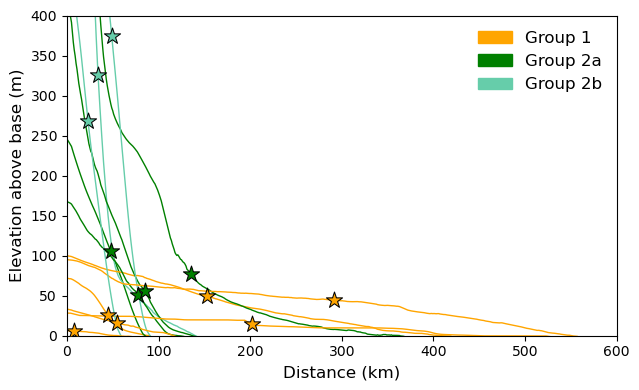

In [194]:
# -----------------------------------------------------
# Plot fan topographic profiles using predefined groups
# -----------------------------------------------------

plt.figure(figsize=(6.5, 4))
ax1 = plt.gca()

window_size_elev = 10  # smoothing window

for fan in df2['Fan'].unique():
    df_fan = df2[df2['Fan'] == fan].copy().sort_values('Distance').reset_index(drop=True)
    
    # Smooth elevations
    df_fan['Confinement_smooth'] = df_fan['Mean Elevation'].rolling(
        window=window_size_elev, min_periods=1, center=True).mean()
    df_fan['River_smooth'] = df_fan['River Elevation'].rolling(
        window=window_size_elev, min_periods=1, center=True).mean()
    
    # Normalize elevation so lowest point = 0
    min_elev = df_fan['Confinement_smooth'].min()
    df_fan['River_norm'] = df_fan['River_smooth'] - min_elev
    
    # Assign group and color using your predefined logic
    group = assign_group(fan)
    color = colors.get(group, 'gray')
    
    # Plot normalized river elevation
    ax1.plot(df_fan['Distance'], df_fan['River_norm'],
             color=color, linewidth=1, label=fan)
    
    # Apex markers (colored stars with black outlines)
    apex_idx = df_fan[df_fan['Apex'].isin(['Apex', 'Both'])].index
    if len(apex_idx) > 0:
        ax1.scatter(df_fan.loc[apex_idx, 'Distance'],
                    df_fan.loc[apex_idx, 'River_norm'],
                    facecolor=color, edgecolor='black',
                    marker='*', s=150, linewidth=.75, zorder=5)

# -----------------------------------------------------
# Axis and panel settings
# -----------------------------------------------------
ax1.set_ylabel('Elevation above base (m)', fontsize=12)
ax1.set_ylim(0, 400)
ax1.set_xlabel('Distance (km)', fontsize=12)
ax1.set_xlim(left=0)  # remove gap between 0 and y-axis
ax1.grid(False)

# -----------------------------------------------------
# Legend (Groups only)
# -----------------------------------------------------
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=colors[g], label=g) for g in colors.keys()]
ax1.legend(handles=handles, fontsize=12, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


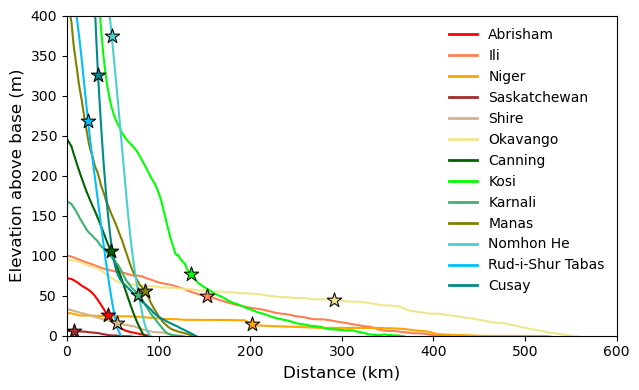

In [205]:
# -----------------------------------------------------
# Plot fan topographic profiles (individual fan colors)
# -----------------------------------------------------

plt.figure(figsize=(6.5, 4))
ax1 = plt.gca()

window_size_elev = 10  # smoothing window

# Manually define fan colors (in desired legend order)
fan_colors = {
    # Group 1
    "Abrisham": "red",
    "Ili": "coral", 
    "Niger": "orange",
    "Saskatchewan": "brown",
    "Shire": "tan",
    "Okavango": "khaki",
    # Group 2a
    "Canning": "darkgreen",
    "Kosi": "lime",
    "Karnali": "mediumseagreen",
    "Manas": "olive",
    # Group 2b
    "Nomhon He": "mediumturquoise",
    "Rud-i-Shur Tabas": "deepskyblue",
    "Cusay": "darkcyan"
}

# -----------------------------------------------------
# Plot each fan’s profile
# -----------------------------------------------------
for fan in fan_colors.keys():  # ensure order matches dictionary
    if fan not in df2['Fan'].unique():
        continue
    df_fan = df2[df2['Fan'] == fan].copy().sort_values('Distance').reset_index(drop=True)
    
    # Smooth elevations
    df_fan['Confinement_smooth'] = df_fan['Mean Elevation'].rolling(
        window=window_size_elev, min_periods=1, center=True).mean()
    df_fan['River_smooth'] = df_fan['River Elevation'].rolling(
        window=window_size_elev, min_periods=1, center=True).mean()
    
    # Normalize elevation so lowest point = 0
    min_elev = df_fan['Confinement_smooth'].min()
    df_fan['River_norm'] = df_fan['River_smooth'] - min_elev
    
    color = fan_colors[fan]
    
    # Plot line
    ax1.plot(df_fan['Distance'], df_fan['River_norm'],
             color=color, linewidth=1.5, label=fan)
    
    # Apex markers (colored star with black outline)
    apex_idx = df_fan[df_fan['Apex'].isin(['Apex', 'Both'])].index
    if len(apex_idx) > 0:
        ax1.scatter(df_fan.loc[apex_idx, 'Distance'],
                    df_fan.loc[apex_idx, 'River_norm'],
                    facecolor=color, edgecolor='black',
                    marker='*', s=120, linewidth=0.75, zorder=5)

# -----------------------------------------------------
# Axis and panel settings
# -----------------------------------------------------
ax1.set_ylabel('Elevation above base (m)', fontsize=12)
ax1.set_ylim(0, 400)
ax1.set_xlabel('Distance (km)', fontsize=12)
ax1.set_xlim(left=0)
ax1.grid(False)

# -----------------------------------------------------
# Legend (preserving manual color order)
# -----------------------------------------------------
handles = [plt.Line2D([0], [0], color=fan_colors[fan], lw=2, label=fan)
           for fan in fan_colors.keys()]
ax1.legend(handles=handles, fontsize=10, loc='upper right', frameon=False, ncol=1)

plt.tight_layout()
plt.show()


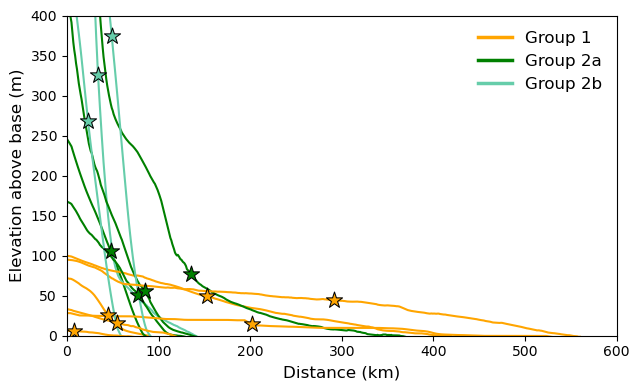

In [207]:
# -----------------------------------------------------
# Plot fan topographic profiles using predefined groups
# -----------------------------------------------------

plt.figure(figsize=(6.5, 4))
ax1 = plt.gca()

window_size_elev = 10  # smoothing window

for fan in df2['Fan'].unique():
    df_fan = df2[df2['Fan'] == fan].copy().sort_values('Distance').reset_index(drop=True)
    
    # Smooth elevations
    df_fan['Confinement_smooth'] = df_fan['Mean Elevation'].rolling(
        window=window_size_elev, min_periods=1, center=True).mean()
    df_fan['River_smooth'] = df_fan['River Elevation'].rolling(
        window=window_size_elev, min_periods=1, center=True).mean()
    
    # Normalize elevation so lowest point = 0
    min_elev = df_fan['Confinement_smooth'].min()
    df_fan['River_norm'] = df_fan['River_smooth'] - min_elev
    
    # Assign group and color using predefined logic
    group = assign_group(fan)
    color = colors.get(group, 'gray')
    
    # Plot normalized river elevation
    ax1.plot(df_fan['Distance'], df_fan['River_norm'],
             color=color, linewidth=1.5, label=group)
    
    # Apex markers (colored stars with black outlines)
    apex_idx = df_fan[df_fan['Apex'].isin(['Apex', 'Both'])].index
    if len(apex_idx) > 0:
        ax1.scatter(df_fan.loc[apex_idx, 'Distance'],
                    df_fan.loc[apex_idx, 'River_norm'],
                    facecolor=color, edgecolor='black',
                    marker='*', s=150, linewidth=.75, zorder=5)

# -----------------------------------------------------
# Axis and panel settings
# -----------------------------------------------------
ax1.set_ylabel('Elevation above base (m)', fontsize=12)
ax1.set_ylim(0, 400)
ax1.set_xlabel('Distance (km)', fontsize=12)
ax1.set_xlim(left=0)
ax1.grid(False)

# -----------------------------------------------------
# Legend (line samples instead of color boxes)
# -----------------------------------------------------
handles = [
    plt.Line2D([0], [0], color=color, lw=2.5, label=group)
    for group, color in colors.items()
]
ax1.legend(handles=handles, fontsize=12, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()
